# Fake News through Stance Detection

## Problem

Detecting whether an article is Fake News using Stance Detection. Stance detection takes a headline and body text of an article and classifies the stance of the body text relative to headline. 

In [100]:
import pandas as pd 

import os
import re
import nltk
from sklearn import feature_extraction
from tqdm import tqdm


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns
from nltk.stem import WordNetLemmatizer

from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

In [101]:
bodies = pd.read_csv('./train_bodies.csv')
stances = pd.read_csv('./train_stances.csv')


## EDA

In [102]:
bodies.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [103]:
stances.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [104]:
stances[stances['Body ID'] == 712]

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1787,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss
3974,Mexico police find mass grave near site 43 stu...,712,unrelated
4936,Mexico Says Missing Students Not Found In Firs...,712,unrelated
5210,New iOS 8 bug can delete all of your iCloud do...,712,unrelated
5863,Return of the Mac: Seth Rogen in talks to star...,712,discuss
6199,Seth Rogen Is Woz,712,discuss
6756,Mexico finds 4 more graves at site of suspecte...,712,unrelated
7526,Are missing students in mass graves found near...,712,unrelated
9003,Mexico prosecutor: Students not in 1st mass gr...,712,unrelated


In [105]:
stances['Body ID'].value_counts()

1921    187
1948    175
40      172
524     171
1549    166
304     154
1385    151
125     145
2367    143
220     141
1438    141
195     140
2296    136
35      131
1786    131
1883    131
2520    127
1034    127
2252    126
1574    125
2307    125
527     125
2175    124
1627    123
2404    123
1289    122
2115    121
2096    120
1040    118
1893    117
       ... 
907       1
370       1
210       1
146       1
114       1
1542      1
63        1
76        1
390       1
515       1
193       1
464       1
355       1
323       1
624       1
282       1
18        1
797       1
701       1
362       1
2311      1
6         1
915       1
70        1
151       1
376       1
140       1
307       1
1066      1
59        1
Name: Body ID, Length: 1683, dtype: int64

In [106]:
stances['Stance'].unique()

array(['unrelated', 'agree', 'disagree', 'discuss'], dtype=object)

In [107]:
print('Bodies shape:', bodies.shape)
print('Stances shape:', stances.shape)


Bodies shape: (1683, 2)
Stances shape: (49972, 3)


In [108]:
stances['Stance'].value_counts()/stances.shape[0]

unrelated    0.731310
discuss      0.178280
agree        0.073601
disagree     0.016809
Name: Stance, dtype: float64

In [109]:
#why are stances rows much larger

In [110]:
bodies.isnull().sum()

Body ID        0
articleBody    0
dtype: int64

In [111]:
stances.isnull().sum()

Headline    0
Body ID     0
Stance      0
dtype: int64

In [112]:
bodies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 2 columns):
Body ID        1683 non-null int64
articleBody    1683 non-null object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


In [113]:
stances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
Headline    49972 non-null object
Body ID     49972 non-null int64
Stance      49972 non-null object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [114]:
print("Total stances: " + str(len(stances.Stance)))
print("Total article bodies: " + str(len(bodies.articleBody)))

Total stances: 49972
Total article bodies: 1683


In [115]:
#merge on bodyID 

df_all = stances.merge(bodies, on = 'Body ID')
#df_all = df_all.drop('Stance', axis =1)
df_all.head()

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\n\n...
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\n\n...


In [116]:
df_all.isnull().sum()

Headline       0
Body ID        0
Stance         0
articleBody    0
dtype: int64

In [117]:
df_all.shape

(49972, 4)

## Baseline

In [118]:
stances['Stance'].value_counts(normalize=True)

unrelated    0.731310
discuss      0.178280
agree        0.073601
disagree     0.016809
Name: Stance, dtype: float64

# NLP

## Count Vectorizer

In [119]:
#body
X_train = df_all[['articleBody']]
y_train = stances['Stance']
X_test = df_all[['articleBody']]
y_test = stances['Stance']

cvec_body = CountVectorizer(stop_words = 'english')

train_body_cvec = cvec_body.fit_transform(X_train['articleBody'])
test_body_cvec = cvec_body.transform(X_test['articleBody'])

lr = LogisticRegression()
lr.fit(train_body_cvec, y_train)
lr.score(test_body_cvec, y_test)

0.7320899703834147

In [120]:
#headline
X_train = df_all[['Headline']]
y_train = stances['Stance']
X_test = df_all[['Headline']]
y_test = stances['Stance']

cvec_headline= CountVectorizer(stop_words = 'english')

train_headline_cvec = cvec_headline.fit_transform(X_train['Headline'])
test_headline_cvec = cvec_headline.transform(X_test['Headline'])

lr = LogisticRegression()
lr.fit(train_headline_cvec, y_train)
lr.score(test_headline_cvec, y_test)

0.7313495557512207

In [121]:
#combine headline and body cvec and that will be x_train
#fit model on X_train 
#if model doesnt do well do truncated svd then cosine similarity between bodies and headline which will become a feature 


In [122]:
#do i still need these 
#df  = pd.DataFrame(X_test_count.todense(),
                   #columns=cvec.get_feature_names(), index = [bodies.articleBody]) 
#df.head()


In [123]:
#df.sort_index(axis = 0, ascending=False).head()

In [124]:
#df.sum().sort_values(ascending=False).head(10)

In [125]:
#df = df.reindex_axis(df.sum().sort_values(ascending=False).index, axis =1)
#df

# Hashing Vectorizer

In [126]:
#body
X_train = df_all[['articleBody']]
y_train = stances['Stance']
X_test = df_all[['articleBody']]
y_test = stances['Stance']

In [127]:
hvec_body = HashingVectorizer(stop_words = 'english')

train_body_hvec = hvec_body.fit_transform(X_train['articleBody'])
test_body_hvec = hvec_body.transform(X_test['articleBody'])

lr = LogisticRegression()
lr.fit(train_body_hvec, y_train)
lr.score(test_body_hvec, y_test)

0.7313095333386697

In [128]:
#headline
X_train = df_all[['Headline']]
y_train = stances['Stance']
X_test = df_all[['Headline']]
y_test = stances['Stance']

In [129]:
hvec_headline = HashingVectorizer(stop_words = 'english')

train_headline_hvec = hvec_headline.fit_transform(X_train['Headline'])
test_headline_hvec = hvec_headline.transform(X_test['Headline'])

lr = LogisticRegression()
lr.fit(train_headline_hvec, y_train)
lr.score(test_headline_hvec, y_test)

0.7313095333386697

In [130]:
#df_hv = pd.DataFrame(hvec.transform(X_test).todense(), index=[bodies.articleBody])  
#df_hv.head()

In [131]:
#df_hv.sum().sort_values(ascending=False).head(10)

In [132]:
#df_hv = df_hv.reindex_axis(df_hv.sum().sort_values(ascending=False).index, axis =1)
#df_hv

In [133]:
#what can i do with this 

# TF IDF 

In [134]:
#body
X_train = df_all[['articleBody']]
y_train = stances['Stance']
X_test = df_all[['articleBody']]
y_test = stances['Stance']

In [135]:
tvec_body = TfidfVectorizer(stop_words = 'english')

train_body_tvec = tvec_body.fit_transform(X_train['articleBody'])
test_body_tvec = tvec_body.transform(X_test['articleBody'])

lr = LogisticRegression()
lr.fit(train_body_tvec, y_train)
lr.score(test_body_tvec, y_test)

0.7313095333386697

In [136]:
#headline
X_train = df_all[['Headline']]
y_train = stances['Stance']
X_test = df_all[['Headline']]
y_test = stances['Stance']

In [137]:
tvec_headline = TfidfVectorizer(stop_words = 'english')

train_headline_tvec = tvec_headline.fit_transform(X_train['Headline'])
test_headline_tvec = tvec_headline.transform(X_test['Headline'])

lr = LogisticRegression()
lr.fit(train_headline_tvec, y_train)
lr.score(test_headline_tvec, y_test)

0.7313095333386697

In [138]:
#df_tfidf  = pd.DataFrame(tvec.transform(X_test).todense(),
                   #columns=tvec.get_feature_names(),
                   #index=[bodies.articleBody])
#df_tfidf.head()
#df.transpose().sort_values('bodies.articleBody', ascending=False).head(10).transpose()

In [139]:
#df_tfidf.sort_index(axis = 0, ascending=False).head()

In [140]:
#df_tfidf.sum().sort_values(ascending=False).head(10)

In [141]:
#df_tfidf = df_tfidf.reindex_axis(df_tfidf.sum().sort_values(ascending=False).index, axis =1)
#df_tfidf

## LDA

In [142]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
        1. Tokenizes and removes punctuation
        2. Removes stopwords
        3. Stems
        4. Returns a list of the cleaned text
    '''
    if pd.isnull(text):
        return []
    # tokenizing and removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
    
    # stemming
    #porter_stemmer = PorterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer()
    
    text_processed = [wordnet_lemmatizer.lemmatize(word) for word in text_processed]
    
    try:
        text_processed.remove('b')
    except: 
        pass

    return text_processed ## <-- we're keeping our words distinct

In [143]:
df_all['articleBody'] = df_all['articleBody'].apply(text_process)

In [144]:
df_all['articleBody'].head()

0    [danny, boyle, directing, untitled, film, seth...
1    [danny, boyle, directing, untitled, film, seth...
2    [danny, boyle, directing, untitled, film, seth...
3    [danny, boyle, directing, untitled, film, seth...
4    [danny, boyle, directing, untitled, film, seth...
Name: articleBody, dtype: object

In [145]:
df_all['Headline'] = df_all['Headline'].apply(text_process)

In [146]:
df_all['Headline'].head()

0    [police, find, mass, graf, least, 15, body, ne...
1           [seth, rogen, play, apple, steve, wozniak]
2    [mexico, police, find, mass, grave, near, site...
3    [mexico, say, missing, student, found, first, ...
4          [new, io, 8, bug, delete, icloud, document]
Name: Headline, dtype: object

## Fit LDA Model

In [149]:
from gensim import corpora, models
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

np.random.seed(42)

## LDA Article Body

In [49]:
dictionary = corpora.Dictionary(df_all['articleBody'])

corpus = [dictionary.doc2bow(text) for text in df_all['articleBody']]

ldamodel = models.ldamodel.LdaModel(corpus,                     # pass in our corpus
                                    id2word = dictionary,       # matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 20,             # number of topics T to find
                                    passes = 5,                 # number of passes through corpus; similar to number of epochs
                                    minimum_probability = 0.01) # only include topics above this probability threshold

In [50]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
17     8.472820        1       1  0.226878 -0.019106
9      7.594943        1       2 -0.112292 -0.000422
2      7.311407        1       3 -0.083543 -0.021565
13     6.791108        1       4 -0.108503  0.080766
8      6.466342        1       5  0.174058 -0.042058
7      5.406430        1       6 -0.187085 -0.060062
14     5.100570        1       7  0.112053  0.049263
3      4.986405        1       8  0.218529 -0.084038
12     4.938589        1       9 -0.117559  0.017820
6      4.882221        1      10  0.059653 -0.100942
0      4.623837        1      11  0.111733 -0.080455
19     4.126440        1      12 -0.143797 -0.016096
1      4.123426        1      13  0.024209  0.294694
18     4.007947        1      14 -0.105914  0.023174
5      3.879497        1      15 -0.103316 -0.141880
4      3.818963        1      16 -0.013768  0.042428
16     3.808404        1      17 -0.129776 -0.044186
10     3.591984        1      18 -0.102502 -0.032554
11     3.399824        1      19  0.109928  0.261605
15     2.668844        1      20  0.171015 -0.126388, topic_info=     Category           Freq          Term          Total  loglift  logprob
term                                                                       
6     Default   44045.000000         apple   44045.000000  30.0000  30.0000
1574  Default   30442.000000         watch   30442.000000  29.0000  29.0000
2527  Default   22236.000000           kim   22236.000000  28.0000  28.0000
97    Default   28784.000000            al   28784.000000  27.0000  27.0000
1218  Default   46117.000000         video   46117.000000  26.0000  26.0000
818   Default   34001.000000           isi   34001.000000  25.0000  25.0000
861   Default   20626.000000         north   20626.000000  24.0000  24.0000
353   Default   24473.000000        police   24473.000000  23.0000  23.0000
1180  Default   16882.000000         foley   16882.000000  22.0000  22.0000
363   Default   17942.000000          shot   17942.000000  21.0000  21.0000
3992  Default   13910.000000         brown   13910.000000  20.0000  20.0000
210   Default  130182.000000          said  130182.000000  19.0000  19.0000
343   Default   26540.000000       islamic   26540.000000  18.0000  18.0000
914   Default   41793.000000         state   41793.000000  17.0000  17.0000
107   Default   17448.000000        border   17448.000000  16.0000  16.0000
2895  Default   10801.000000         ebola   10801.000000  15.0000  15.0000
944   Default   47036.000000             u   47036.000000  14.0000  14.0000
2644  Default   12495.000000          jong   12495.000000  13.0000  13.0000
1215  Default   22614.000000         syria   22614.000000  12.0000  12.0000
563   Default   20635.000000      american   20635.000000  11.0000  11.0000
296   Default   29728.000000           man   29728.000000  10.0000  10.0000
816   Default   19261.000000          iraq   19261.000000   9.0000   9.0000
279   Default   16631.000000          girl   16631.000000   8.0000   8.0000
803   Default   33140.000000         group   33140.000000   7.0000   7.0000
1621  Default   13616.000000       officer   13616.000000   6.0000   6.0000
1785  Default   10156.000000         haram   10156.000000   5.0000   5.0000
1737  Default   10093.000000          boko   10093.000000   4.0000   4.0000
2649  Default   10183.000000         korea   10183.000000   3.0000   3.0000
43    Default   11492.000000           job   11492.000000   2.0000   2.0000
240   Default   10498.000000            un   10498.000000   1.0000   1.0000
...       ...            ...           ...            ...      ...      ...
8168  Topic20     478.529205       malaria     479.479614   3.6215  -6.4029
3573  Topic20     594.342590        frisco     595.917297   3.6209  -6.1861
1075  Topic20    4736.536621        banksy    4924.335938   3.5846  -4.1105
2227  Topic20    1919.250610        artist    1969.0045

## LDA Headline

In [51]:
dictionary = corpora.Dictionary(list(df_all['Headline']))

corpus = [dictionary.doc2bow(text) for text in df_all['Headline']]

ldamodel = models.ldamodel.LdaModel(corpus,                     # pass in our corpus
                                    id2word = dictionary,       # matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 20,             # number of topics T to find
                                    passes = 5,                 # number of passes through corpus; similar to number of epochs
                                    minimum_probability = 0.01) # only include topics above this probability threshold

In [52]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
7      7.175739        1       1  0.160565 -0.236766
15     6.986013        1       2 -0.055301  0.092987
9      6.434521        1       3 -0.047171  0.080033
6      6.159083        1       4  0.033375 -0.118654
5      5.968647        1       5  0.172359  0.133394
19     5.822701        1       6  0.031229  0.184130
13     5.576653        1       7  0.031246 -0.039357
12     5.277154        1       8  0.190933  0.063809
16     4.846416        1       9 -0.262180  0.068002
11     4.759069        1      10  0.150684  0.096401
10     4.680370        1      11 -0.265636  0.023132
0      4.676740        1      12 -0.080662  0.049703
14     4.424639        1      13  0.220810 -0.044855
2      4.332467        1      14 -0.112297 -0.026703
4      4.281420        1      15 -0.079351 -0.041128
8      4.159107        1      16 -0.078881 -0.186555
3      3.989267        1      17  0.038145 -0.165177
18     3.813822        1      18  0.042447  0.220686
1      3.670227        1      19 -0.152054 -0.093390
17     2.965941        1      20  0.061741 -0.059691, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
221   Default  2875.000000       state  2875.000000  30.0000  30.0000
69    Default  6749.000000         isi  6749.000000  29.0000  29.0000
436   Default  2292.000000         kim  2292.000000  28.0000  28.0000
217   Default  2870.000000     islamic  2870.000000  27.0000  27.0000
14    Default  2829.000000       apple  2829.000000  26.0000  26.0000
430   Default  2661.000000       foley  2661.000000  25.0000  25.0000
435   Default  2099.000000        jong  2099.000000  24.0000  24.0000
73    Default  3714.000000           u  3714.000000  23.0000  23.0000
18    Default  1731.000000       steve  1731.000000  22.0000  22.0000
431   Default  2402.000000       james  2402.000000  21.0000  21.0000
468   Default  1844.000000       haram  1844.000000  20.0000  20.0000
465   Default  1844.000000        boko  1844.000000  19.0000  19.0000
37    Default  1624.000000         job  1624.000000  18.0000  18.0000
437   Default  1779.000000          un  1779.000000  17.0000  17.0000
94    Default  2009.000000      leader  2009.000000  16.0000  16.0000
80    Default  2329.000000       watch  2329.000000  15.0000  15.0000
505   Default  1652.000000       brown  1652.000000  14.0000  14.0000
432   Default  2153.000000  journalist  2153.000000  13.0000  13.0000
504   Default  1580.000000       audio  1580.000000  12.0000  12.0000
56    Default  2210.000000     michael  2210.000000  11.0000  11.0000
452   Default  2631.000000       video  2631.000000  10.0000  10.0000
428   Default  1920.000000    american  1920.000000   9.0000   9.0000
467   Default  1490.000000        girl  1490.000000   8.0000   8.0000
98    Default  1155.000000   christian  1155.000000   7.0000   7.0000
97    Default  1155.000000        bale  1155.000000   6.0000   6.0000
15    Default  1193.000000        play  1193.000000   5.0000   5.0000
486   Default  1056.000000          al  1056.000000   4.0000   4.0000
180   Default  1605.000000    militant  1605.000000   3.0000   3.0000
506   Default  1395.000000    shooting  1395.000000   2.0000   2.0000
12    Default  1026.000000     student  1026.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
1235  Topic20    54.135845      agrees    55.081535   3.5007  -5.4582
1519  Topic20    53.068871        pack    54.014561   3.5003  -5.4781
1515  Topic20    53.068871        brat    54.014561   3.5003  -5.4781
1041  Topic20    52.950623   cawthorne    53.896313   3.5003  -5.4804
1105  Topic20    47.330612      briton    48.276302   3.4982  -5.5926
1987  Topic20    46.501282      timing    47.446972   3.4978  -5.6102
1988  Topic20    46.501282    verifies    47.446972   3.4978 

### preprocessing for Latent Semantic Analysis

In [ ]:
#need this cleaner to make vectorizers below work....idk why

In [152]:
import re

In [153]:
def cleaner(text):
    text = re.sub('&#39;','',text).lower()
    text = re.sub('<br />','',text)
    text = re.sub('<.*>.*</.*>','', text)
    text = re.sub('\\ufeff', '', text)
    text = re.sub('[\d]','',text)
    text = re.sub('[^a-z ]','',text)
    
    return text

<input>:6: DeprecationWarning: invalid escape sequence \d
<input>:6: DeprecationWarning: invalid escape sequence \d
<input>:6: DeprecationWarning: invalid escape sequence \d
<ipython-input-153-6de38bea8180>:6: DeprecationWarning: invalid escape sequence \d
  text = re.sub('[\d]','',text)


In [154]:
df_all['articleBody'] = df_all['articleBody'].map(str)
df_all['articleBody'] = df_all['articleBody'].apply(cleaner)

In [56]:
df_all['articleBody'].iloc[1]

'danny boyle directing untitled film seth rogen eyed play apple co founder steve wozniak sony steve job biopic danny boyle directing untitled film based walter isaacson book adapted aaron sorkin one anticipated biopics recent year negotiation yet begun even clear rogen official offer producer scott rudin guymon casady mark gordon set sight talent talk course may naught christian bale actor play job still midst closing deal source say dealmaking process sensitive stage insider say boyle flying los angeles meet actress play one female lead assistant job insider say jessica chastain one actress meeting list wozniak known woz co founded apple job ronald wayne first met job worked atari later responsible creating early apple computer'

In [155]:
df_all['Headline'] = df_all['Headline'].map(str)
df_all['Headline'] = df_all['Headline'].apply(cleaner)

In [168]:
df_all.head()
#why does this change my text processing back 

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\n\n...
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\n\n...


In [247]:
df_all.to_csv('./preprocessed.csv')

### tfidf vectorizer

In [156]:
tfidf_vector = TfidfVectorizer(min_df = 5, stop_words='english')

articleBody_matrix_sparse = tfidf_vector.fit_transform(df_all['articleBody'])
articleBody_matrix_sparse

<49972x18408 sparse matrix of type '<class 'numpy.float64'>'
	with 6480420 stored elements in Compressed Sparse Row format>

In [157]:
articleBody_df_tfdf = pd.DataFrame(articleBody_matrix_sparse.toarray(),
                                 index = df_all.index,
                                 columns = tfidf_vector.get_feature_names())

In [158]:
articleBody_df_tfdf.head()

,aafia,aamaq,aamir,aan,aapl,aaron,aback,abadam,abadi,abagnale,...,zobl,zone,zoning,zoology,zor,zubayr,zubeyr,zuckerberg,zulu,zxycaeuwb
0,0.0,0.0,0.0,0.0,0.0,0.07737,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.07737,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.07737,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.07737,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.07737,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
headline_matrix_sparse = tfidf_vector.fit_transform(df_all['Headline'])
headline_matrix_sparse

<49972x2736 sparse matrix of type '<class 'numpy.float64'>'
	with 388147 stored elements in Compressed Sparse Row format>

In [62]:
headline_df_tfdf = pd.DataFrame(headline_matrix_sparse.toarray(),
                                 index = df_all.index,
                                 columns = tfidf_vector.get_feature_names())

In [63]:
headline_df_tfdf.head()

,aaron,abandoned,abdel,abdi,abducted,abducting,abdul,abdullah,abort,aborted,...,younger,youngest,youtube,ypg,yum,zack,zehaf,zeppelin,zero,zhejiang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Truncated SVD

In [64]:
from sklearn.decomposition import TruncatedSVD

In [65]:
n_components = 100
SVD = TruncatedSVD(n_components)
component_names = ["component_"+str(i) for i in range(n_components)]

In [66]:
#lsa = TruncatedSVD(n_components=100, n_iter=100)
#lsa.fit(articleBody_df_tfdf)

In [67]:
#lsa.components_[0]

In [68]:
#terms = vectorizer.get_feature_names()
#for i, comp in enumerate(lsa.components_):
    #termsInComp = zip (terms, comp)
    #sortedTerms = sorted(termsInComp, key=lambda X: x[1], reverse = True)[:10]
    #print "Word %d:" % i
    #for term in sortedTerms:
        #print term[0]
        #print " "

In [69]:
articleBody_svd_matrix = SVD.fit_transform(articleBody_df_tfdf)
articleBody_svd_matrix

array([[ 0.09533842,  0.20917657, -0.02623447, ..., -0.01842468,
        -0.01329635,  0.00160345],
       [ 0.09533842,  0.20917657, -0.02623447, ..., -0.01842468,
        -0.01329635,  0.00160345],
       [ 0.09533842,  0.20917657, -0.02623447, ..., -0.01842468,
        -0.01329635,  0.00160345],
       ...,
       [ 0.10926743, -0.00405857, -0.01237433, ..., -0.0078137 ,
         0.01992944, -0.00284108],
       [ 0.17433645,  0.51243759, -0.07441561, ..., -0.03089425,
        -0.01542923, -0.01088547],
       [ 0.16292306,  0.66241464, -0.1288089 , ..., -0.0098862 ,
        -0.01244625, -0.02435808]])

In [70]:
headline_svd_matrix = SVD.fit_transform(headline_df_tfdf)
headline_svd_matrix

array([[ 0.01147472,  0.00935667,  0.00474699, ...,  0.05792497,
        -0.06416471,  0.0664541 ],
       [ 0.00723122,  0.05075079, -0.00227505, ...,  0.01528682,
        -0.02149199,  0.00855633],
       [ 0.01427154,  0.00729155,  0.00614716, ...,  0.05510026,
        -0.05917941,  0.0499812 ],
       ...,
       [ 0.01233532,  0.00230594,  0.00526008, ..., -0.00503097,
        -0.029953  ,  0.02016431],
       [ 0.01735207,  0.01500696,  0.00583619, ..., -0.01005641,
         0.00682132, -0.00083453],
       [ 0.00979547,  0.01030194,  0.00912457, ..., -0.01906919,
         0.03719339, -0.0674999 ]])

In [71]:
articleBody_svd_matrix.shape

(49972, 100)

In [72]:
#search_term = "islam"

#use headline to compare to the boody 
#make a list forbody and article and loop thru each row 

In [73]:
#search_term_vec = tfidf_vector.transform([search_term])

In [74]:
#search_term_svd = SVD.transform(search_term_vec)

In [75]:
#search_term_svd

## Cosine Similarity

In [169]:
#cosine_similarities = articleBody_svd_matrix.dot(search_term_svd.T).ravel()
#do for 1 row with another row --> feature 

In [ ]:
#cosine_similarities.shape

In [ ]:
#cosine_similarities

In [ ]:
#cosine_similarities.argsort()[:-6:-1]

In [ ]:
#cosine_similarities_headline = headline_svd_matrix.dot(search_term_svd.T).ravel()

In [ ]:
from gensim import corpora, models
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [ ]:
#from nltk.corpus import stopwords
#def split_into_words(documents):
    #docs = []
    #for doc in documents:
        #text_processed = doc.split(' ')
        #text_processed = list(filter(lambda a: a != '', text_processed))
        #text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
        #docs.append(text_processed)
    #return docs

In [ ]:
#texts = split_into_words(df_all['articleBody'])

## Cosine Similarity

In [177]:
import scipy.spatial as sp

In [178]:
#distances = 1 - sp.distance.cdist(articleBody_svd_matrix, headline_svd_matrix, 'cosine')

In [185]:
distances = []
for i, body in enumerate(articleBody_svd_matrix): 
    distances.append(sp.distance.cdist([body], [headline_svd_matrix[i]], 'cosine')[0][0])

In [186]:
df_all['distances'] = pd.Series(distances)

In [187]:
df_all.shape

(49972, 5)

### Eliminating Nulls

In [201]:
df_fix = pd.DataFrame(df_all['distances'], df_all['Body ID'], df_all['Stance'])

In [ ]:
df_fix.T.head()

In [ ]:
#2 null values 
df_all.shape

In [164]:
df_all = df_all.dropna(axis=0)

#why does this change my df to not a df 

In [165]:
df_all.shape

(49972, 4)

In [166]:
df_all = stances.merge(bodies, on = 'Body ID')

In [167]:
df_all.head()

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\n\n...
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\n\n...


In [87]:
df_fix.head()

,distances
0,0.852089
1,0.952722
2,0.834662
3,0.766238
4,0.965413


In [170]:
df_fix[df_fix['distances'].isnull()==True]

,distances


In [171]:
df_fix = df_fix.dropna(axis=0)

In [172]:
df_fix.shape

(49970, 1)

In [173]:
df_all[df_all['distances'].isnull()==True]

KeyError: 'distances'

### Adding labels to stances

In [88]:
from sklearn import preprocessing

In [89]:
le = preprocessing.LabelEncoder()
le.fit(df_all['Stance'])
print("Classes:", list(le.classes_))
stance_label = le.transform(df_all['Stance']) 


Classes: ['agree', 'disagree', 'discuss', 'unrelated']


In [90]:
stance_label

array([3, 2, 3, ..., 0, 2, 2])

In [205]:
df_all['stance_dummy'] = pd.Series(stance_label)

In [206]:
df_all.head()

,Headline,Body ID,Stance,articleBody,distances,stance_dummy
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...,0.852089,3
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\n\n...,0.952722,2
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\n\n...,0.834662,3
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\n\n...,0.766238,3
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\n\n...,0.965413,3


In [94]:
stance_dummy = pd.get_dummies(df_all['Stance'], drop_first=False)
stance_dummy.head()

,agree,disagree,discuss,unrelated
0,0,0,0,1
1,0,0,1,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [213]:
df_fix = pd.DataFrame([df_all['distances'], df_all['stance_dummy']]).T
df_fix = df_fix.dropna(axis=0)

In [209]:
from sklearn.model_selection import train_test_split

In [214]:
X = df_fix['distances'].reshape(df_fix['distances'].shape[0], 1)
y = df_fix['stance_dummy']

X_train, X_test, y_train, y_test = train_test_split(X, y)

/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


In [215]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37477, 1), (12493, 1), (37477,), (12493,))

In [216]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.7311150839181365

In [217]:
lr.score(X_test, y_test)

0.7304090290562715

In [218]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.9577340769004989

In [219]:
rf.score(X_test, y_test)

0.6058592811974706

In [220]:
np.unique(y_train)

array([0., 1., 2., 3.])

### ROC Curve

In [221]:
from sklearn.metrics import roc_auc_score

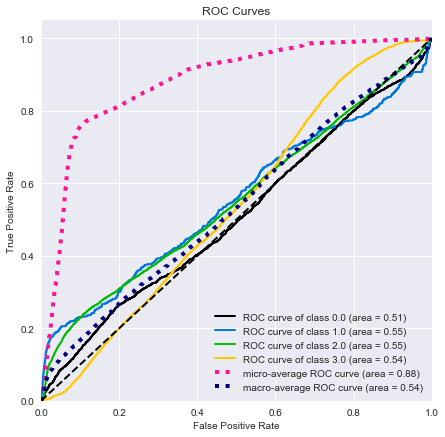

In [222]:
y_probas = lr.predict_proba(X_train)
y_true = y_train

import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc(y_true, y_probas, figsize=(7,7))
plt.show()

In [223]:
y_true.unique(), y_true.shape

(array([0., 2., 3., 1.]), (37477,))

In [224]:
np.unique(y_probas), y_probas.shape

(array([0.00824913, 0.00836858, 0.0084015 , ..., 0.85144266, 0.85193765,
        0.85317672]), (37477, 4))

In [225]:
y_probas

array([[0.07295073, 0.01753116, 0.16325486, 0.74626326],
       [0.0733424 , 0.01733988, 0.16720562, 0.7421121 ],
       [0.07812462, 0.01509475, 0.22186265, 0.68491798],
       ...,
       [0.06771186, 0.02024899, 0.11705255, 0.7949866 ],
       [0.07144225, 0.01828136, 0.14871705, 0.76155935],
       [0.07412021, 0.0169639 , 0.17527474, 0.73364115]])

In [226]:
from imblearn.over_sampling import RandomOverSampler

In [227]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0.0, 36544), (1.0, 36544), (2.0, 36544), (3.0, 36544)]


In [228]:
lr = LogisticRegression()
lr.fit(X_resampled, y_resampled)
lr.score(X_resampled, y_resampled)

0.27486728327495624

# Model with cvec body, cvec head, and cosine similarity

In [229]:
cvec_vector = CountVectorizer(stop_words='english')

cvec_articleBody_matrix_sparse = cvec_vector.fit_transform(df_all['articleBody'])
cvec_articleBody_matrix_sparse

<49972x22888 sparse matrix of type '<class 'numpy.int64'>'
	with 6940629 stored elements in Compressed Sparse Row format>

In [230]:
cvec_body_array = cvec_articleBody_matrix_sparse.toarray()

In [231]:
df_cvec = pd.DataFrame(cvec_body_array)

In [232]:
df_cvec.head()

,0,1,2,3,4,5,6,7,8,9,...,22878,22879,22880,22881,22882,22883,22884,22885,22886,22887
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [233]:
cvec_vector = CountVectorizer(stop_words='english')

cvec_headline_matrix_sparse = cvec_vector.fit_transform(df_all['Headline'])

cvec_headline_matrix_sparse

<49972x3167 sparse matrix of type '<class 'numpy.int64'>'
	with 403082 stored elements in Compressed Sparse Row format>

In [234]:
cvec_vector.get_feature_names

<bound method CountVectorizer.get_feature_names of CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)>

In [235]:
cvec_headline_df = pd.DataFrame(cvec_headline_matrix_sparse.todense(),
                       columns = cvec_vector.get_feature_names())


In [236]:
cvec_headline_df.shape

(49972, 3167)

In [237]:
df_fix.shape

(49970, 2)

In [238]:
df_headline_fix = pd.concat([df_fix, cvec_headline_df], axis=1)

In [239]:
df_headline_fix.fillna(value=0, inplace=True)

In [241]:
features = [col for col in df_headline_fix.columns if col != 'stance_dummy']

In [242]:
X = df_headline_fix[features]
y = df_headline_fix['stance_dummy']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [243]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.7292884015048428

In [244]:
lr.score(X_test, y_test)

0.7258464740254542

In [245]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.977053816804077

In [246]:
rf.score(X_test, y_test)

0.7650684383254622

## GloVe


In [322]:
df_glove = pd.DataFrame([df_all['Headline'], df_all['articleBody']]).T

In [323]:
df_glove

,Headline,articleBody
0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film\n\n...
1,Seth Rogen to Play Apple’s Steve Wozniak,Danny Boyle is directing the untitled film\n\n...
2,Mexico police find mass grave near site 43 stu...,Danny Boyle is directing the untitled film\n\n...
3,Mexico Says Missing Students Not Found In Firs...,Danny Boyle is directing the untitled film\n\n...
4,New iOS 8 bug can delete all of your iCloud do...,Danny Boyle is directing the untitled film\n\n...
5,Return of the Mac: Seth Rogen in talks to star...,Danny Boyle is directing the untitled film\n\n...
6,Seth Rogen Is Woz,Danny Boyle is directing the untitled film\n\n...
7,Mexico finds 4 more graves at site of suspecte...,Danny Boyle is directing the untitled film\n\n...
8,Are missing students in mass graves found near...,Danny Boyle is directing the untitled film\n\n...
9,Mexico prosecutor: Students not in 1st mass gr...,Danny Boyle is directing the untitled film\n\n...


In [332]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

max_sequence_length = 200   # max number of words to consider in a review (i.e. the first 50...)
max_num_words = 4000       # maximum number of words to include in the vocabulary (i.e. top 10000 only)

# Instantiate the Tokenizer
tokenizer = Tokenizer(num_words=max_num_words)

# Fit the tokenizer, i.e. learn the vocab and id the most frequently occuring words
tokenizer.fit_on_texts(df_all['Headline'].values)

# Turn our texts to sequences of word indices
sequences = tokenizer.texts_to_sequences(df_all['Headline'].values)

# Save the look-up dictionary for words to indices (will need this later)
word_index = tokenizer.word_index

# Pad out our sequences by prepending zeros to all of our text sequences
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

print(f'Found {len(word_index)} unique tokens/words')
print(f'The maximum word index is {padded_sequences.max()}')

Found 3879 unique tokens/words
The maximum word index is 3879


In [333]:
padded_sequences_headline.shape

(49972, 200)

In [334]:
padded_sequences_headline[0,:]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [296]:
max_sequence_length = 200   # max number of words to consider in a review (i.e. the first 50...)
max_num_words = 25000       # maximum number of words to include in the vocabulary (i.e. top 10000 only)

# Instantiate the Tokenizer
tokenizer = Tokenizer(num_words=max_num_words)

# Fit the tokenizer, i.e. learn the vocab and id the most frequently occuring words
tokenizer.fit_on_texts(df_all['articleBody'].values)

# Turn our texts to sequences of word indices
sequences = tokenizer.texts_to_sequences(df_all['articleBody'].values)

# Save the look-up dictionary for words to indices (will need this later)
word_index = tokenizer.word_index

# Pad out our sequences by prepending zeros to all of our text sequences
padded_sequences_articleBody = pad_sequences(sequences, maxlen=max_sequence_length)

print(f'Found {len(word_index)} unique tokens/words')
print(f'The maximum word index is {padded_sequences.max()}')

Found 27427 unique tokens/words
The maximum word index is 3879


In [297]:
padded_sequences_articleBody.shape

(49972, 200)

In [298]:
padded_sequences_articleBody[0,:]

array([    0,     0,     0,  1961,  1800,     8,  4690,     1,  5513,
         473,  2509,  1702,     8,    83,  8293,     2,   688,    45,
         528,  1102,   524,  2033,     5,  8243,   524,   381,  1542,
        1961,  1800,     8,  4690,     1,  5513,   473,   291,    10,
        2300,  3475,   912,     6, 12238,    19,  1626,   935,    42,
           8,    40,     4,     1,   169,  2848, 12239,     5,   312,
         133,  1155,    17,    25,   317,  3047,     6,   186,    25,
         115,   521,    64,  1702,    20,    24,   145,   988,    29,
           1,  3300,    87,  3533,  6192,  6282,  6283,     6,   565,
        2432,    87,    17,   314,    50,  4662,    10,     1,  6512,
           6,    26,     5,   729,     4,   996,    30,   110,    57,
          23,    11, 17192,    18,   868,   564,     1,   677,    32,
           8,     2,   688,   381,     8,   142,     5,     1,  5021,
           4,  6051,    16,   645,   246,   132,     7, 17193,  1624,
           8,     5,

In [309]:
padded_sequences = np.concatenate((padded_sequences_headline, padded_sequences_articleBody), axis=1)
padded_sequences.shape

(49972, 400)

In [308]:
df_all['stance_dummy'].shape

(49972,)

In [335]:
# Train, test split, baby...
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df_all['stance_dummy'], test_size=0.33, random_state=42)

X_train.shape, y_train.shape

((33481, 200), (33481,))

In [336]:
import numpy as np

glove_dir = './glove.6B'

embeddings_index = {}

with open(os.path.join(glove_dir, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
print(f'Found {len(embeddings_index)} word vectors')

Found 400000 word vectors


In [337]:
embedding_dim = 100

embedding_matrix = np.zeros((max_num_words, embedding_dim))
for word, index in word_index.items():
    if index < max_num_words:
        # Using "get" with the dict is a safe way to avoid missing key errors
        embedding_vector = embeddings_index.get(word) 
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [338]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(max_num_words, embedding_dim, input_length=max_sequence_length))
model.add(LSTM(20))
model.add(Dense(1, activation='sigmoid'))

In [339]:
model.layers[0].set_weights([embedding_matrix])

In [340]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          400000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 20)                9680      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 409,701
Trainable params: 409,701
Non-trainable params: 0
_________________________________________________________________


In [341]:
history = model.fit(X_train, y_train, epochs=5, batch_size=400, validation_data=(X_test, y_test))

Train on 33481 samples, validate on 16491 samples
Epoch 1/5
33481/33481 [==============================] - 43s 1ms/step - loss: -5.4855 - acc: 0.0183 - val_loss: -10.4723 - val_acc: 0.0165
Epoch 2/5
33481/33481 [==============================] - 42s 1ms/step - loss: -12.6599 - acc: 0.0170 - val_loss: -14.2511 - val_acc: 0.0165
Epoch 3/5
33481/33481 [==============================] - 43s 1ms/step - loss: -15.9769 - acc: 0.0170 - val_loss: -17.3168 - val_acc: 0.0165
Epoch 4/5
33481/33481 [==============================] - 44s 1ms/step - loss: -19.0108 - acc: 0.0170 - val_loss: -20.2820 - val_acc: 0.0165
Epoch 5/5
33481/33481 [==============================] - 43s 1ms/step - loss: -21.9626 - acc: 0.0170 - val_loss: -23.0694 - val_acc: 0.0165


In [342]:
# What's baseline?# What's 
np.unique(y_train, return_counts=True)[1]/len(y_train)

array([0.07180192, 0.01696485, 0.17693617, 0.73429706])

In [343]:
X_test[0:1,:].shape

(1, 200)

In [344]:
model.predict(X_test[0:1,:])

array([[0.99999964]], dtype=float32)

In [ ]:
#need to do fo bodies 

### body

In [ ]:
model = Word2Vec(df_all['articleBody'], size=100, window=5, min_count=1, workers=4)
body_w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

In [ ]:
df_body_w2v = pd.DataFrame(body_w2v)
df_body_w2v.head()

## Model with word2vec articleBody + headline 

In [281]:
#from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

# TRAIN_SET_PATH = "20ng-no-stop.txt"
# TRAIN_SET_PATH = "r52-all-terms.txt"
TRAIN_SET_PATH = "r8-no-stop.txt"

GLOVE_6B_50D_PATH = "glove.6B.50d.txt"
GLOVE_840B_300D_PATH = "glove.840B.300d.txt"
encoding="utf-8"

In [349]:
ls = []
sentences = df_glove.split(".")
for i in sentences:
    ls.append(i.split())
model = Word2Vec(df_glove, min_count=1, size = 4)
words = list(model.wv.vocab)
print(words)
vectors = []
for word in words:
    vectors.append(model[word].tolist())
data = np.array(vectors)
data

AttributeError: 'DataFrame' object has no attribute 'split'

In [ ]:
df_w2v_fix = pd.concat([df_body_w2v, df_w2v], axis=1)
df_w2v_fix.head()

In [ ]:
df_w2v_fix.shape

In [ ]:
df_fix['Unnamed 0'].shape

In [ ]:
X = df_w2v_fix
y = df_fix['Unnamed 0'] #need to create binary for classes #predict the prob of each class and highest use as predictions

X_train, X_test, y_train, y_test = train_test_split(X, y)